In [1]:
import os
import torch
import argparse
import numpy as np
import pandas as pd
from util import * 
from model import *
from pandas import DataFrame
import sklearn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 
from transformers import BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from DNA_Bert_finetuning_average_L2_for_sequence_attention_analyze_util import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/lijiahao/anaconda3/envs/tensorflow_pytorch_python/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoches',              type=int,  default=300,  help='')
parser.add_argument('--batch_size',           type=int,  default=16,  help='')
parser.add_argument('--max_length',           type=int,  default=200, help='')
parser.add_argument('--learning_rate',        type=float, default=1e-4, help="")
parser.add_argument('--model_path',           type=str,  default="../3-new-12w-0", help='')

parser.add_argument('--ind_filename',  type=str,  default="../dataset/enhancer_3-mer_DNABERT_ind.txt", help='')
parser.add_argument('--tra_filename',  type=str,  default="../dataset/enhancer_3-mer_DNABERT_tra.txt", help='')

args = parser.parse_args(args=[]) 

mer = 3
args.model_path = "../{}-new-12w-0".format(mer)

In [3]:
# the different of kmer between enhancer and non enhancer

enhancer_sequence_filename = "sequence/enhancer_sequence_instance.txt"
non_enhancer_sequence_filename = "sequence/non_enhancer_sequence_instance.txt"

enhancer_sequence_token_embeddings, enhancer_token_keys = get_attention_for_sequence_token(args, enhancer_sequence_filename, mer)
print(enhancer_sequence_token_embeddings.shape)
"""
enhancer_sequence_token_embeddings.shape: (number_batch-size, batch_size, max_length, 768)
# print("enhancer_sequence_token_embeddings: {}; enhancer_token_keys: {}".format(enhancer_sequence_token_embeddings.shape, enhancer_token_keys.shape))
"""





# # record the scatter token embedding
# token_scatter = np.load("sequence/scatter_token_embedding.npy", allow_pickle=True)
# scatter_token_embedding_dict = {}
# for item in token_scatter:
#     if item[0] not in scatter_token_embedding_dict.keys():
#         scatter_token_embedding_dict[item[0]] = []
#     scatter_token_embedding_dict[item[0]].append(item[1])

# # enhancer token embedding
# enhancer_token_embedding_dict = {}
# for index in range(len(enhancer_sequence_token_embeddings)):
#     token_embeddings = enhancer_sequence_token_embeddings[index][0]
#     token_keys = enhancer_token_keys[index]
 
#     for i in range(len(token_keys)):
#         if token_keys[i] not in enhancer_token_embedding_dict.keys():
#             enhancer_token_embedding_dict[token_keys[i]] = []
#         enhancer_token_embedding_dict[token_keys[i]].append(token_embeddings[i])
    
# # non-enhancer token embedding
# non_enhancer_token_embedding_dict = {}
# for index in range(len(non_enhancer_sequence_token_embeddings)):
#     token_embeddings = non_enhancer_sequence_token_embeddings[index][0]
#     token_keys = non_enhancer_token_keys[index]
   
#     for i in range(len(token_keys)):
#         if token_keys[i] not in non_enhancer_token_embedding_dict.keys():
#             non_enhancer_token_embedding_dict[token_keys[i]] = []
#         non_enhancer_token_embedding_dict[token_keys[i]].append(token_embeddings[i])

# token = "CCT" # good behave 
# # token = "TCC" # good behave 
# token_embeddings = []
# token_length_scatter = len(scatter_token_embedding_dict[token])
# token_length_enhancer = len(enhancer_token_embedding_dict[token])
# token_length_non_enhancer = len(non_enhancer_token_embedding_dict[token])
# print("length of scatter:{}, length of token in enhancer: {}, length of token in non-enhancer: {}".format(token_length_scatter, token_length_enhancer, token_length_non_enhancer))
# token_embeddings += scatter_token_embedding_dict[token]
# token_embeddings += enhancer_token_embedding_dict[token]
# token_embeddings += non_enhancer_token_embedding_dict[token]

# token_embedding_tsne_proj = tsne(token_embeddings)

# scatter_token_embedding_proj = token_embedding_tsne_proj[0:token_length_scatter]
# enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter:token_length_scatter+token_length_enhancer]
# non_enhancer_token_embedding_proj = token_embedding_tsne_proj[token_length_scatter+token_length_enhancer:token_length_scatter+token_length_enhancer+token_length_non_enhancer]

# plt.figure(figsize=(10, 10))
# ax = plt.subplot(1,1,1)
# ax.scatter(scatter_token_embedding_proj[:,0], scatter_token_embedding_proj[:,1], marker="*", c="red", s=250, label="Scatter Token")
# ax.scatter(enhancer_token_embedding_proj[:, 0], enhancer_token_embedding_proj[:, 1], marker="o", c="green", s=50, label="{} of enhancer".format(token))
# ax.scatter(non_enhancer_token_embedding_proj[:, 0], non_enhancer_token_embedding_proj[:, 1], marker="o", c="orange", s=50, label="{} of non-enhancer".format(token))

# plt.xticks([])
# plt.yticks([])
# plt.title("the t-SNE projection of token-{} in enhancer and non-enhancer sequences".format(token))
# plt.legend()
# plt.savefig("image/Token-{}_t-sne_projection.svg".format(token), bbox_inches='tight')
# plt.show()

Some weights of the model checkpoint at ../3-new-12w-0 were not used when initializing C_Bert_2FC_average_atten: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing C_Bert_2FC_average_atten from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing C_Bert_2FC_average_atten from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of C_Bert_2FC_average_atten were not initialized from the model checkpoint at ../3-new-12w-0 and are newly initialized: ['classi

(1, 12, 200, 200)
(2, 12, 200, 200)
(3, 12, 200, 200)
(4, 12, 200, 200)
(5, 12, 200, 200)
(6, 12, 200, 200)
(7, 12, 200, 200)
(8, 12, 200, 200)
(9, 12, 200, 200)
(10, 12, 200, 200)
(11, 12, 200, 200)
(12, 12, 200, 200)
(13, 12, 200, 200)
(14, 12, 200, 200)
(15, 12, 200, 200)
(16, 12, 200, 200)
(17, 12, 200, 200)
(18, 12, 200, 200)
(19, 12, 200, 200)
(20, 12, 200, 200)
(21, 12, 200, 200)
(22, 12, 200, 200)
(23, 12, 200, 200)
(24, 12, 200, 200)
(25, 12, 200, 200)
(26, 12, 200, 200)
(27, 12, 200, 200)
(28, 12, 200, 200)
(29, 12, 200, 200)
(30, 12, 200, 200)
(31, 12, 200, 200)
(32, 12, 200, 200)
(33, 12, 200, 200)
(34, 12, 200, 200)
(35, 12, 200, 200)
(36, 12, 200, 200)
(37, 12, 200, 200)
(38, 12, 200, 200)
(39, 12, 200, 200)
(40, 12, 200, 200)
(41, 12, 200, 200)
(42, 12, 200, 200)
(43, 12, 200, 200)
(44, 12, 200, 200)
(45, 12, 200, 200)
(46, 12, 200, 200)
(47, 12, 200, 200)
(48, 12, 200, 200)
(49, 12, 200, 200)
(50, 12, 200, 200)
(51, 12, 200, 200)
(52, 12, 200, 200)
(53, 12, 200, 200)
(5

'\nenhancer_sequence_token_embeddings.shape: (number_batch-size, batch_size, max_length, 768)\n# print("enhancer_sequence_token_embeddings: {}; enhancer_token_keys: {}".format(enhancer_sequence_token_embeddings.shape, enhancer_token_keys.shape))\n'

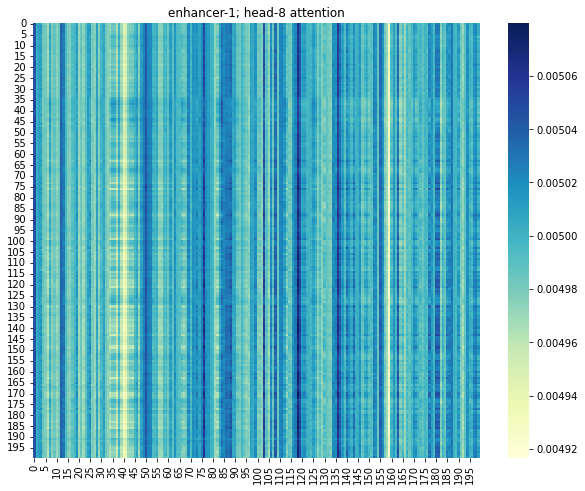

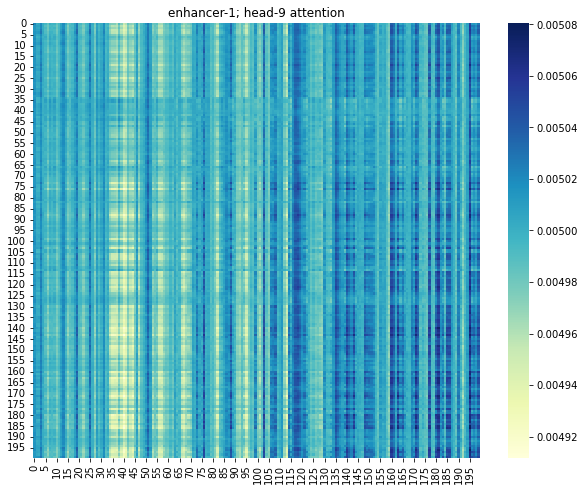

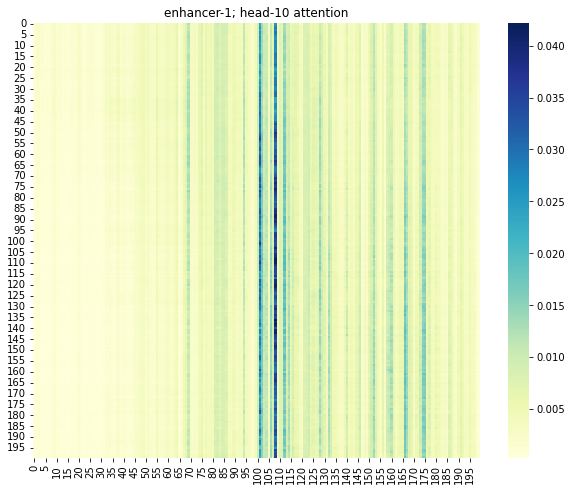

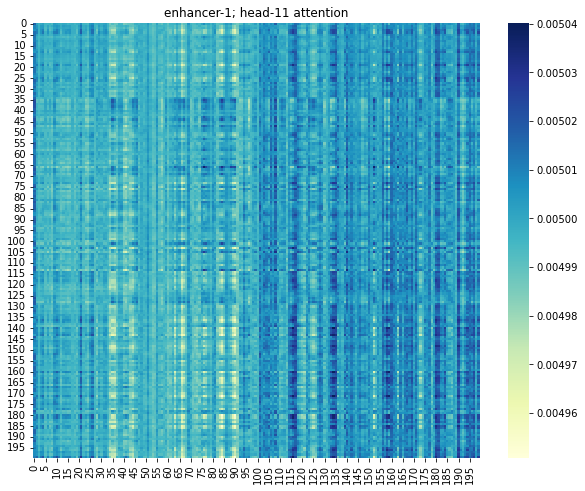

In [11]:
import seaborn as sns 
def calculate_attention_heatmap(enhancer_sequence_token_attention, enhancer_token_keys, enhancer_index, head):
    enhancer_attention = enhancer_sequence_token_attention[enhancer_index][head]
    enhancer_sequence = enhancer_token_keys[enhancer_index]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(enhancer_attention, cmap="YlGnBu")
    ax.set_title("enhancer-{}; head-{} attention".format(enhancer_index, head))

    
    # plt.savefig("./atten/figure/{}.svg".format(motif_index), format="svg", bbox_inches ="tight")
    plt.show()
calculate_attention_heatmap(enhancer_sequence_token_embeddings, enhancer_token_keys, 1, 8)
calculate_attention_heatmap(enhancer_sequence_token_embeddings, enhancer_token_keys, 1, 9)
calculate_attention_heatmap(enhancer_sequence_token_embeddings, enhancer_token_keys, 1, 10)
calculate_attention_heatmap(enhancer_sequence_token_embeddings, enhancer_token_keys, 1, 11)

In [4]:
# # for scatter token embedding

# args.tra_filename = "./sequence/scatter_token.txt"
# tra_dataloader = getData(args, split=False, validation=False, shuffle=True)
# token_embeddings, token = get_embedding_for_scatter_token(args, tra_dataloader, mer)

# scatter_token_embedding = []
# for item in zip(token, token_embeddings):
#     scatter_token_embedding.append(item)

# np.save("sequence/scatter_token_embedding", scatter_token_embedding)
# print("({}, {})".format(len(token_embeddings), len(token_embeddings[0])))
# print(token)

# 从上面的例子中，选择一条enhancer，分析在该序列当中，token与位置之间的差异
# 单个序列里面，token的embedding可视化分析
index = 64

token_embeddings = enhancer_sequence_token_embeddings[index][0]
token_keys = enhancer_token_keys[index]

# record the scatter token embedding

token_embedding_single_dict = {}    
for i in range(len(token_keys)):
    if token_keys[i] not in token_embedding_single_dict.keys():
        token_embedding_single_dict[token_keys[i]] = []
    token_embedding_single_dict[token_keys[i]].append(token_embeddings[i])

token_embedding = []
token_embedding += scatter_token_embedding_dict[token]
token_embedding += token_embedding_single_dict[token]

token_length_scatter = len(scatter_token_embedding_dict[token])
token_embedding_single = len(token_embedding_single_dict[token])

token_embeddings_tsne_proj = tsne(token_embedding)

plt_scatter(token_embeddings_tsne_proj, "Token-{}-Scatter Token vs Contextual Token of Single".format(token))

cos_token_embedding = cosine_similarity(token_embedding)

for i in range(len(cos_token_embedding)):
    for j in range(len(cos_token_embedding[0])):
        print("{: .4f}".format(cos_token_embedding[i,j]), end="; ")
    print()
    

NameError: name 'scatter_token_embedding_dict' is not defined

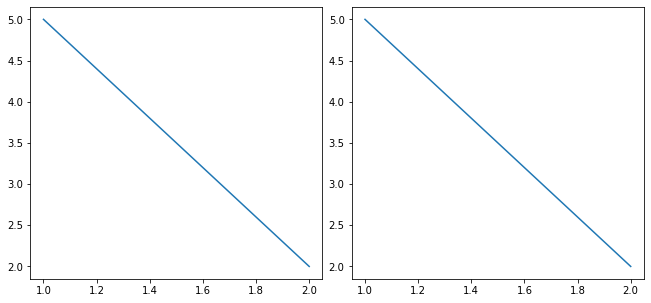

In [ ]:
a = {}

if "a" not in a.keys():
    print("asd")

else:
    print("asdfasf")


asd


[[1. 2. 3.]
 [1. 3. 2.]]
[[2. 1. 1.]
 [1. 1. 1.]]
[[0.76376262 0.9258201 ]
 [0.76376262 0.9258201 ]]
0.9258200997725516
